In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

# Low-Pass Filter

It allows high frequencies to pass while **removing low frequencies**.

$$\eta_{truth} \rightarrow  \eta_{truth} - \eta_{truth}^{BM}$$

## Loading Data

In [2]:
sshdedac = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60_dedac/ssh_dedac_masked_*.nc", combine="nested", concat_dim="time_counter", parallel=True)

In [3]:
sshdedac

<xarray.Dataset> Size: 47GB
Dimensions:       (y: 853, x: 788, time_counter: 8760)
Coordinates:
    nav_lat       (y, x) float32 3MB dask.array<chunksize=(853, 788), meta=np.ndarray>
    nav_lon       (y, x) float32 3MB dask.array<chunksize=(853, 788), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 70kB 2014-01-01T00:30:00 ... ...
    latitude      (y, x) float32 3MB dask.array<chunksize=(853, 788), meta=np.ndarray>
    longitude     (y, x) float32 3MB dask.array<chunksize=(853, 788), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    ssh_dedac     (time_counter, y, x) float64 47GB dask.array<chunksize=(744, 853, 788), meta=np.ndarray>

In [3]:
sshdedac = sshdedac.drop_vars(['latitude','longitude'])

# Rename nav_lat and nav_lon to lat and lon
sshdedac = sshdedac.rename({'nav_lat': 'lat', 'nav_lon': 'lon'})

# Since lat and lon are 2D coordinates, make sure to assign them properly to your dataset
sshdedac = sshdedac.assign_coords(lat=(('y', 'x'), sshdedac.lat.values),
                                  lon=(('y', 'x'), sshdedac.lon.values))

## Gaussian Kernel

The actual separation into BM and HF components involves applying the Gaussian filter to the [SSH - DAC]  data. In a nutshell, the BM is directly calculated by applying a rolling window operation followed by a dot product with the Gaussian weights, normalized by the sum of the weights.

### Coriolis Parameter

The Coriolis parameter, by $f$, is a factor that **describes** the effect of the Earth's rotation **on moving objects**. It is defined as:

$$ f = 2 \Omega \sin(\phi) $$

where:

- $\Omega$ is the angular velocity of the Earth's rotation (~7.292E-5 [rad/s] which is calculated from $2\pi$ over 86164, which is the time of a sideral year in seconds.)
- $\phi$ is the latitude of the location in question.

The Coriolis parameter varies with latitude, affecting the movement of objects differently depending on their location on the Earth's surface. It's zero at the Equator and increases/decreases in magnitude toward the poles. 

### Coriolis Period

This equation gives the period of a pendulum oscillating freely under the influence of the Coriolis force at the given latitude.

$$T = \frac{2\pi}{f}$$

In [10]:
# Setting some variables for ease of use later on
longitude = sshdedac.lon.values
latitude = sshdedac.lat.values
time = sshdedac.time_counter.values
nt = time.size
ny = latitude.size
nx = longitude.size

f = 2*(2*np.pi/86164)*np.sin(np.mean(np.deg2rad(latitude))) # Coriolis parameter (-4.75e-05)
T = np.abs(2*np.pi/f) # Including absolute becase the periode has to be positive. (132281.2) 

dt = 3600 # number of seconds in a hour 
window_len = int(2*T//dt) # length of the gaussian filter window (73 hours ~ 3 days)
time_window = np.arange(-window_len,window_len+1) # array time steps to compute the kernel (ok)
exp_window = np.exp(-np.square(time_window/(T/dt))) # array of kernel values (ok)
ntw = time_window.size #(147)
weight = xr.DataArray(exp_window, dims=['window']) #(ok)

In [5]:
# Making a dataarray
sshdedac_da = sshdedac['ssh_dedac']

# Cropping days with out NaNs (becasue last 6 hours were not interpolated)
sshdedac_da = sshdedac_da.isel(time_counter=slice(0, 8754))

### The Gaussian Function

$$G(t) = \exp^{-\frac{t^2}{2\sigma^{2}}}$$

Where $G(t)$ is the weight given by the Gaussian Function at time $t$, $t$ is the time offset from the central point, and $\sigma$ is the standart deviation of $G(t)$. The latter is related to the coriolis period ($T$) and the temporal resolution and $\mathrm{d}t$ controls the spread of $G(t)$.

### Time window

It is the **array** time step to compute the kernel. The goal is to stablish a range of indices that spans from (-) ``window_len`` to (+) ``window_len`` (inclusive) to eventually weight the neighboring points along the Gaussian Function. It is symetric at 0 (the central point).

<span style="font-size:0.8em;">**What is an array?** A collection of items of same data type stored ar at a contiguous memory allocation.</span>

In [6]:
rolling_sshdedac_da = sshdedac_da.rolling(time_counter=ntw, center=True).construct('window') # Constructing the rolling window

## Calculating BM and HF

Some acronyms: **HF** : High Frequency, **BM** : Balanced Motions, **BAR** : Barotropic Tide, **IGW** : Internal Gravity Waves, and **IT** : Internal Tide.

### Balance Motion

In [7]:
ssh_bm = rolling_sshdedac_da.dot(weight, dims=['window']) / weight.sum() # Applying the gaussian filter

In [8]:
ssh_bm

<xarray.DataArray (time_counter: 8754, y: 853, x: 788)> Size: 47GB
dask.array<truediv, shape=(8754, 853, 788), dtype=float64, chunksize=(806, 853, 788), chunktype=numpy.ndarray>
Coordinates:
    lat           (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    lon           (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
  * time_counter  (time_counter) datetime64[ns] 70kB 2014-01-01T00:30:00 ... ...
Dimensions without coordinates: y, x

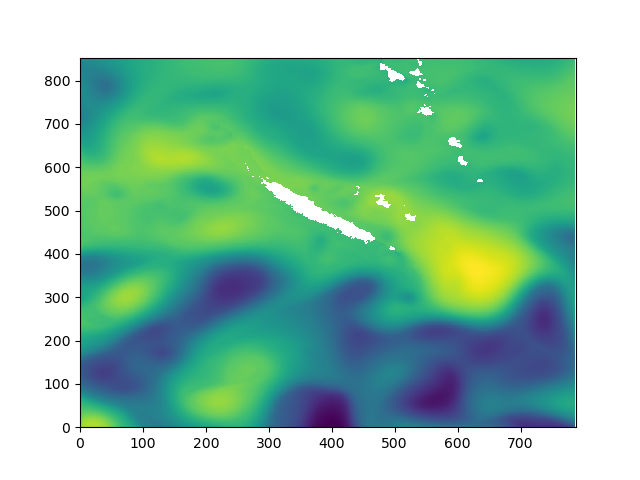

In [9]:
plt.pcolormesh(ssh_bm[1000]) # quick plot

#### Plot 

In [ ]:
# # Getting max and min for the color bar (results: max = 1.1072834287170326 and min = 0.11842590430584532)

# # Initialize variables to track the global max and min
# global_max = float('-inf')
# global_min = float('inf')

# # Generate a Pandas date range for each month in your dataset's time range
# # Adjust the start and end dates according to your dataset
# start_date = '2014-01-01'
# end_date = '2014-12-31'
# monthly_periods = pd.date_range(start=start_date, end=end_date, freq='M')

# # Loop through each month
# for start in monthly_periods:
#     end = start + pd.offsets.MonthEnd()
#     # Select the data for the current month
#     # Ensure to use .compute() if working with Dask to load the data into memory
#     monthly_data = ssh_bm.sel(time_counter=slice(start, end))
    
#     # Compute max and min for the current month
#     monthly_max = monthly_data.max().values
#     monthly_min = monthly_data.min().values
    
#     # Update global max and min
#     global_max = max(global_max, monthly_max)
#     global_min = min(global_min, monthly_min)

# # Print the global max and min
# print(f'Global maximum value: {global_max}')
# print(f'Global minimum value: {global_min}')

# # Takes like 35 min to execute


In [ ]:
selected_date = '2014-01-10T00:30:00'  # Example: Adjust to your desired date
data_on_date = ssh_bm.sel(time_counter=selected_date)

plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Copy the 'curl' colormap to modify it
new_cmap = cmocean.cm.curl.copy()
# Set NaN values to black in the new colormap
new_cmap.set_bad('black', 1.)

# Dynamically determine min and max values from your data slice
min_val = -1
max_val = 1

# Use pcolormesh with the axis object, applying the modified colormap
pcolormesh = ax.pcolormesh(ssh_bm['lon'], ssh_bm['lat'], data_on_date,
                           cmap=new_cmap, vmin=min_val, vmax=max_val)

# Add colorbar and label it, here we use shrink
cbar = plt.colorbar(pcolormesh, ax=ax, shrink=0.95)
cbar.set_label('Height (m)')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Balanced Motion Dynamics at ' + str(selected_date))

# Add land with higher resolution to the main plot on top, filled black
ax.add_feature(cfeature.LAND.with_scale('10m'), edgecolor='black', facecolor='black', zorder=3)

# Add gridlines with labels to the main plot
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}

# Fix the aspect ratio
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


### Heigher Frequencies

In [ ]:
ssh_hf = sshdedac_da - ssh_bm

#### Plot

In [ ]:
ssh_hf

In [ ]:
# # Getting max and min for the color bar (results: max = 0.951020993288621 and min = -1.0565150874729385)

# # Initialize variables to track the global max and min
# global_max = float('-inf')
# global_min = float('inf')

# # Generate a Pandas date range for each month in your dataset's time range
# # Adjust the start and end dates according to your dataset
# start_date = '2014-01-01'
# end_date = '2014-12-31'
# monthly_periods = pd.date_range(start=start_date, end=end_date, freq='M')

# # Loop through each month
# for start in monthly_periods:
#     end = start + pd.offsets.MonthEnd()
#     # Select the data for the current month
#     # Ensure to use .compute() if working with Dask to load the data into memory
#     monthly_data = ssh_hf.sel(time_counter=slice(start, end))
    
#     # Compute max and min for the current month
#     monthly_max = monthly_data.max().values
#     monthly_min = monthly_data.min().values
    
#     # Update global max and min
#     global_max = max(global_max, monthly_max)
#     global_min = min(global_min, monthly_min)

# # Print the global max and min
# print(f'Global maximum value: {global_max}')
# print(f'Global minimum value: {global_min}')

# # Takes like 37 min to execute


In [ ]:
selected_date = '2014-01-10T00:30:00'  # Example: Adjust to your desired date
data_on_date = ssh_hf.sel(time_counter=selected_date)

plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Copy the 'curl' colormap to modify it
new_cmap = cmocean.cm.curl.copy()
# Set NaN values to black in the new colormap
new_cmap.set_bad('black', 1.)

# Dynamically determine min and max values from your data slice
min_val = -1
max_val = 1

# Use pcolormesh with the axis object, applying the modified colormap
pcolormesh = ax.pcolormesh(ssh_hf['lon'], ssh_hf['lat'], data_on_date,
                           cmap=new_cmap, vmin=min_val, vmax=max_val)

# Add colorbar and label it, here we use shrink
cbar = plt.colorbar(pcolormesh, ax=ax, shrink=0.95)
cbar.set_label('Height (m)')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('High Frequency SSH Signal at ' + str(selected_date))

# Add land with higher resolution to the main plot on top, filled black
ax.add_feature(cfeature.LAND.with_scale('10m'), edgecolor='black', facecolor='black', zorder=3)

# Add gridlines with labels to the main plot
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}

# Fix the aspect ratio
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


# SSH - DAC

In [ ]:
selected_date = '2014-01-10T00:30:00'  # Example: Adjust to your desired date
data_on_date = sshdedac_da.sel(time_counter=selected_date)

plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Copy the 'curl' colormap to modify it
new_cmap = cmocean.cm.deep.copy()
# Set NaN values to black in the new colormap
new_cmap.set_bad('black', 1.)

# Dynamically determine min and max values from your data slice
min_val = -1
max_val = 1

# Use pcolormesh with the axis object, applying the modified colormap
pcolormesh = ax.pcolormesh(ssh_hf['lon'], ssh_hf['lat'], data_on_date,
                           cmap=new_cmap, vmin=min_val, vmax=max_val)

# Add colorbar and label it, here we use shrink
cbar = plt.colorbar(pcolormesh, ax=ax, shrink=0.95)
cbar.set_label('Height (m)')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('SSH - DAC at ' + str(selected_date))

# Add land with higher resolution to the main plot on top, filled black
ax.add_feature(cfeature.LAND.with_scale('10m'), edgecolor='black', facecolor='black', zorder=3)

# Add gridlines with labels to the main plot
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}

# Fix the aspect ratio
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


# Saving BM and HF

In [ ]:
# Your directory path where the files will be saved
directory_path = '/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_bm'

# Ensure the directory exists, create it if it doesn't
os.makedirs(directory_path, exist_ok=True)

# Assuming `ssh_bm` is your loaded DataArray
# Loop through all months
for month in range(1, 13):
    # Select data for the current month
    ssh_bm_month = ssh_bm.sel(time_counter=ssh_bm.time_counter.dt.month == month)
    
    # Define the file name based on the month, including the directory path
    file_name = os.path.join(directory_path, f'ssh_bm_{month:02d}.nc')
    
    # Save to a NetCDF file
    ssh_bm_month.to_netcdf(file_name)
    
    print(f'Saved {file_name}')
    
# Takes like 40 min to execute    


In [2]:
test = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_bm/ssh_bm_01.nc", parallel=True)

In [ ]:
# Your directory path where the files will be saved
directory_path = '/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf'

# Ensure the directory exists, create it if it doesn't
os.makedirs(directory_path, exist_ok=True)

# Assuming `ssh_bh` is your loaded DataArray
# Loop through all months
for month in range(1, 13):
    # Select data for the current month
    ssh_hf_month = ssh_hf.sel(time_counter=ssh_hf.time_counter.dt.month == month)
    
    # Define the file name based on the month, including the directory path
    file_name = os.path.join(directory_path, f'ssh_hf_{month:02d}.nc')
    
    # Save to a NetCDF file
    ssh_hf_month.to_netcdf(file_name)
    
    print(f'Saved {file_name}')
    
# Takes like  min to execute